In [464]:
import os
import numpy as np
import pandas as pd
import torch
import os
import json
import pandas as pd
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline
from tqdm import tqdm
import glob
import pickle

In [465]:
df_des = pd.read_csv('challenge-2019-classes-description-500.csv', names=['label', 'name'])
df_des.head()

,label,name
0,/m/061hd_,Infant bed
1,/m/06m11,Rose
2,/m/03120,Flag
3,/m/01kb5b,Flashlight
4,/m/0120dh,Sea turtle


In [466]:
# visualize

import numpy as np
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

INDIGO = (75, 0, 130)


def draw_bounding_box_on_image(
    image,
    x_min,
    y_min,
    x_max,
    y_max,
    color,
    thickness=4,
    display_str_list=(),
    use_normalized_coordinates=False,
    fontsize=20
):
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    if use_normalized_coordinates:
        (left, right, top, bottom) = (x_min * im_width, x_max * im_width, y_min * im_height, y_max * im_height)
    else:
        (left, right, top, bottom) = (x_min, x_max, y_min, y_max)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)
    try:
        font = ImageFont.truetype('DejaVuSansMono.ttf', fontsize)
    except IOError:
        font = ImageFont.load_default()

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)], fill=color)
        draw.text((left + margin, text_bottom - text_height - margin), display_str, fill=color, font=font)
        text_bottom -= text_height - 2 * margin


def draw_bounding_boxes_on_image_array(
    image, bboxes, color=INDIGO, thickness=4, use_normalized_coordinates=False, fontsize=20
):
    image_pil = Image.fromarray(image)
    draw_bounding_boxes_on_image(image_pil, bboxes, color, thickness, use_normalized_coordinates, fontsize)
    np.copyto(image, np.array(image_pil))


def draw_bounding_boxes_on_image(
    image, bboxes, color=INDIGO, thickness=4, use_normalized_coordinates=False, fontsize=20
):
    for bbox in bboxes:
        draw_bounding_box_on_image(
            image, bbox[0], bbox[1], bbox[2], bbox[3], color, thickness, (), use_normalized_coordinates, fontsize
        )


In [616]:
!ls /mnt/chicm/open-images/work_dirs/cascade_rcnn_x101_64x4d_fpn_1x/0-500

20190718_171029.log	  20190719_080211.log.json  20190719_223519.log.json
20190718_174538.log	  20190719_081018.log	    20190720_030212.log
20190718_174538.log.json  20190719_081018.log.json  20190720_030212.log.json
20190718_175515.log	  20190719_082808.log	    20190720_073324.log
20190718_175832.log	  20190719_082808.log.json  20190720_073324.log.json
20190718_175832.log.json  20190719_104816.log	    20190720_115513.log
20190718_180151.log	  20190719_104816.log.json  20190720_115513.log.json
20190718_180151.log.json  20190719_105909.log	    20190720_162201.log
20190718_181221.log	  20190719_105909.log.json  20190720_162201.log.json
20190718_181221.log.json  20190719_110529.log	    20190721_080714.log
20190718_181600.log	  20190719_110529.log.json  20190721_080714.log.json
20190718_182031.log	  20190719_110846.log	    20190722_173442.log
20190718_182031.log.json  20190719_110846.log.json  20190722_173442.log.json
20190718_182707.log	  20190719_111522.log	    20190722_215903.log
2019071

In [617]:
def get_top_classes(start_index, end_index):
    df = pd.read_csv('top_classes.csv')
    c = df['class'].values[start_index:end_index]
    #print(df.head())
    stoi = { c[i]: i for i in range(len(c)) }
    return c, stoi

In [618]:
# submission

#with open('/mnt/chicm/open-images/preds_0705_bottom400_2.pkl', 'rb') as f:
with open('/mnt/chicm/open-images/work_dirs/cascade_rcnn_x101_64x4d_fpn_1x/0-500/preds_0723.pkl', 'rb') as f:
    preds = pickle.load(f)

classes, stoi = get_top_classes(0, 500)

In [619]:
len(preds[0])

500

In [620]:
classes[:5]

array(['/m/04yx4', '/m/07j7r', '/m/0dzct', '/m/01g317', '/m/03bt1vf'],
      dtype=object)

In [621]:
threshold=0.05
top_threshold = 0.05

def get_threshold(c):
    if c in set(top_100_classes):
        return top_threshold
    else:
        return threshold

In [599]:
get_threshold('/m/0120dh')

0.05

In [641]:
def get_preds(raw_pred):
    res = {
        'labels': [],
        'scores': [],
        'bboxes': []
    }
    for i, p in enumerate(raw_pred):
        if len(p) > 0:
            for e in p:
                #th = get_threshold(classes[i])
                if True: 
                #if e[4] > 0.01:
                    res['labels'].append(i)
                    res['scores'].append(e[4])
                    res['bboxes'].append(e[:4])
    res['labels'] = np.array(res['labels'])
    res['scores'] = np.array(res['scores'])
    res['bboxes'] = np.array(res['bboxes'])
    return res

In [630]:
#print(get_preds(preds[0]))
#tmp = get_preds(preds[0])['labels']
#print(get_preds(preds[0])['scores'])
#print(tmp)
#tmp = [classes[i] for i in tmp]
#print(tmp)
#tmp = [df_des.loc[df_des.label==x].name.values.tolist()[0] for x in tmp]
#print(tmp)

In [623]:
df_test = pd.read_csv('sample_submission.csv')
df_test.head()

,ImageId,PredictionString
0,b5d912e06f74e948,/m/05s2s 0.9 0.46 0.08 0.93 0.5 /m/0c9ph5 0.5 ...
1,be137cf6bb0b62d5,/m/05s2s 0.9 0.46 0.08 0.93 0.5 /m/0c9ph5 0.5 ...
2,8d65ca08cb5ce8e8,/m/05s2s 0.9 0.46 0.08 0.93 0.5 /m/0c9ph5 0.5 ...
3,4d3ad1e52ad8c065,/m/05s2s 0.9 0.46 0.08 0.93 0.5 /m/0c9ph5 0.5 ...
4,9b94408691c7d7bf,/m/05s2s 0.9 0.46 0.08 0.93 0.5 /m/0c9ph5 0.5 ...


In [642]:
TEST_IMG_DIR = '/mnt/chicm/data/open-images/test'
def show_preds(idx):
    plt.figure(figsize=(15, 10))
    p = get_preds(preds[idx])
    img_id = df_test.iloc[idx].ImageId
    fn = os.path.join(TEST_IMG_DIR, '{}.jpg'.format(img_id))
    img = Image.open(fn)
    draw_bounding_boxes_on_image(img, p['bboxes'])
    
    plt.imshow(img)
    labels = [classes[i] for i in p['labels']]
    labels = [df_des.loc[df_des.label==x].name.values[0] for x in labels]
    #print(labels)
    print(list(zip(labels, p['scores'])))

[('Man', 0.5075098), ('Man', 0.14388415), ('Man', 0.11949606), ('Man', 0.011443287), ('Man', 0.011384758), ('Man', 0.008992761), ('Man', 0.0040173656), ('Man', 0.0033923988), ('Human face', 0.5797085), ('Human face', 0.0030906282), ('Person', 0.16263525), ('Person', 0.11680087), ('Person', 0.025184173), ('Person', 0.008565452), ('Person', 0.0068227714), ('Person', 0.004311736), ('Woman', 0.013257993), ('Woman', 0.008909399), ('Woman', 0.004163652), ('Human hair', 0.10114896), ('Human hair', 0.018845726), ('Human hair', 0.008542964), ('Human hair', 0.006340954), ('Human hair', 0.0054087476), ('Human arm', 0.021330148), ('Human arm', 0.018020546), ('Human arm', 0.014961884), ('Human arm', 0.010902665), ('Human arm', 0.010635122), ('Human arm', 0.0070507536), ('Human arm', 0.0036186937), ('Human head', 0.14556861), ('Human head', 0.0033026666), ('Building', 0.0038290923), ('Chair', 0.005364996), ('Suit', 0.009973652), ('Boy', 0.00703049), ('Table', 0.007936767), ('Jeans', 0.003451812), ('

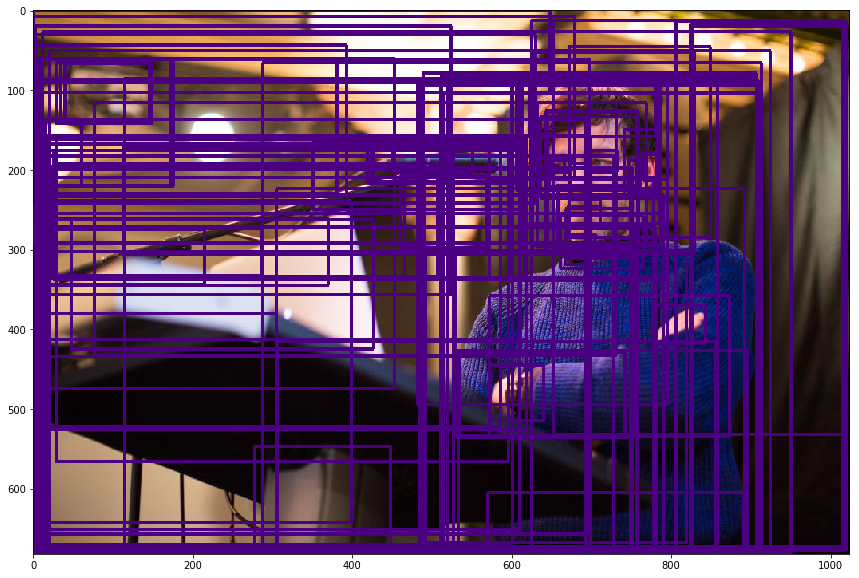

In [644]:
show_preds(1)

In [635]:
import struct
import imghdr

def get_image_size(fname):
    '''Determine the image type of fhandle and return its size.
    from draco'''
    with open(fname, 'rb') as fhandle:
        head = fhandle.read(24)
        if len(head) != 24:
            raise AssertionError('imghead len != 24')
        if imghdr.what(fname) == 'png':
            check = struct.unpack('>i', head[4:8])[0]
            if check != 0x0d0a1a0a:
                raise AssertionError('png check failed')
            width, height = struct.unpack('>ii', head[16:24])
        elif imghdr.what(fname) == 'gif':
            width, height = struct.unpack('<HH', head[6:10])
        elif imghdr.what(fname) == 'jpeg':
            try:
                fhandle.seek(0) # Read 0xff next
                size = 2
                ftype = 0
                while not 0xc0 <= ftype <= 0xcf:
                    fhandle.seek(size, 1)
                    byte = fhandle.read(1)
                    while ord(byte) == 0xff:
                        byte = fhandle.read(1)
                    ftype = ord(byte)
                    size = struct.unpack('>H', fhandle.read(2))[0] - 2
                # We are at a SOFn block
                fhandle.seek(1, 1)  # Skip `precision' byte.
                height, width = struct.unpack('>HH', fhandle.read(4))
            except Exception: #IGNORE:W0703
                raise
        else:
            print(fname, imghdr.what(fname))
            #raise AssertionError('file format not supported')
            img = cv2.imread(fname)
            print(img.shape)
            height, width, _ = img.shape

        return width, height


In [636]:
df_test['h'] = df_test.ImageId.map(lambda x: get_image_size(os.path.join(TEST_IMG_DIR, '{}.jpg'.format(x)))[1])

In [637]:
df_test['w'] = df_test.ImageId.map(lambda x: get_image_size(os.path.join(TEST_IMG_DIR, '{}.jpg'.format(x)))[0])

In [639]:
df_test.head()

,ImageId,PredictionString,h,w
0,b5d912e06f74e948,/m/05s2s 0.9 0.46 0.08 0.93 0.5 /m/0c9ph5 0.5 ...,682,1024
1,be137cf6bb0b62d5,/m/05s2s 0.9 0.46 0.08 0.93 0.5 /m/0c9ph5 0.5 ...,682,1024
2,8d65ca08cb5ce8e8,/m/05s2s 0.9 0.46 0.08 0.93 0.5 /m/0c9ph5 0.5 ...,806,768
3,4d3ad1e52ad8c065,/m/05s2s 0.9 0.46 0.08 0.93 0.5 /m/0c9ph5 0.5 ...,768,961
4,9b94408691c7d7bf,/m/05s2s 0.9 0.46 0.08 0.93 0.5 /m/0c9ph5 0.5 ...,682,1024


In [645]:
final_preds = []

for p in tqdm(preds, total=len(preds)):
    final_preds.append(get_preds(p))

100%|██████████| 99999/99999 [00:37<00:00, 2680.51it/s]


In [646]:
total_objs = 0
for p in final_preds:
    total_objs += len(p['labels'])
print(total_objs)

14164705


In [647]:
def get_pred_str(pred, w, h):
    res = []
    for label, score, bbox in zip(pred['labels'], pred['scores'], pred['bboxes']):
        res.append(classes[label])
        res.append('{:.7f}'.format(score))
        res.append('{:.7f}'.format(bbox[0]/w))
        res.append('{:.7f}'.format(bbox[1]/h))
        res.append('{:.7f}'.format(bbox[2]/w))
        res.append('{:.7f}'.format(bbox[3]/h))
    res = [str(x) for x in res]
    return ' '.join(res)

In [648]:
pred_strs = []
for i, p in tqdm(enumerate(final_preds), total=len(final_preds)):
    h = df_test.iloc[i].h
    w = df_test.iloc[i].w
    pred_strs.append(get_pred_str(p, w, h))
    

100%|██████████| 99999/99999 [04:41<00:00, 355.01it/s]


In [649]:
pred_strs[:5]

['/m/04yx4 0.6027240 0.5351210 0.2290157 0.6374214 0.8391564 /m/04yx4 0.5833477 0.4310889 0.2773204 0.5403278 0.7950365 /m/04yx4 0.4021025 0.3094148 0.2986151 0.4437959 0.8094799 /m/04yx4 0.3309260 0.6225814 0.2859415 0.6879840 0.7106074 /m/04yx4 0.2946967 0.6717530 0.2753294 0.7456874 0.7183794 /m/04yx4 0.0896129 0.8286336 0.2891734 0.9195531 0.6121441 /m/04yx4 0.0769663 0.1936586 0.2685118 0.3226769 0.7790417 /m/04yx4 0.0612422 0.5867252 0.2719334 0.7423920 0.7459519 /m/04yx4 0.0568077 0.1885912 0.2510832 0.7270184 0.8118835 /m/04yx4 0.0364283 0.4730197 0.2822020 0.5230724 0.3796891 /m/04yx4 0.0202796 0.6595656 0.3039460 0.6966511 0.6774741 /m/04yx4 0.0184087 0.4363238 0.3316358 0.5365872 0.5953843 /m/04yx4 0.0174781 0.5388410 0.2461412 0.6022856 0.4423601 /m/04yx4 0.0174534 0.3895305 0.3004107 0.4560723 0.7593787 /m/04yx4 0.0162134 0.6730648 0.3077472 0.7365186 0.4271437 /m/0dzct 0.1341948 0.5620554 0.2603797 0.5926573 0.3231345 /m/0dzct 0.1278152 0.2430246 0.2958069 0.2722656 0.358

In [650]:
len(pred_strs)

99999

In [651]:
df_test.PredictionString = pred_strs
df_test.head()

,ImageId,PredictionString,h,w
0,b5d912e06f74e948,/m/04yx4 0.6027240 0.5351210 0.2290157 0.63742...,682,1024
1,be137cf6bb0b62d5,/m/04yx4 0.5075098 0.4984400 0.1245685 0.88663...,682,1024
2,8d65ca08cb5ce8e8,/m/04yx4 0.0050775 0.3600481 0.0754799 0.98543...,806,768
3,4d3ad1e52ad8c065,/m/04yx4 0.0972933 0.1875077 0.0184985 0.70288...,768,961
4,9b94408691c7d7bf,/m/04yx4 0.0112709 0.5614793 0.0000000 0.67120...,682,1024


In [652]:
df_test.to_csv('sub_cas_0_500_150boxes_0723.csv', index=False, columns=['ImageId', 'PredictionString'])

In [131]:
!head -n 5 sub_cas_0707_400-500_1_005.csv

ImageId,PredictionString
b5d912e06f74e948,/m/061hd_ 0.07095882 0.10641561448574066 0.13219182302525317 0.9912408590316772 0.93853759765625 /m/012n7d 0.05984055 0.04952796921133995 0.18137349551024676 0.9987037777900696 0.9097186225600257 /m/04vv5k 0.068167515 0.0948629155755043 0.21147059555277448 0.784403920173645 0.8669761143122251
be137cf6bb0b62d5,/m/061hd_ 0.14320776 0.0 0.025909068647367865 0.9219979047775269 0.9983333464591734 /m/0llzx 0.07741927 0.0 0.02534067875478974 0.9120415449142456 0.9964463577941716 /m/01pns0 0.057987526 0.3408152461051941 0.2166047977212587 0.6154636144638062 0.7597486210708394 /m/0176mf 0.051837564 0.0 0.343933217336705 0.4291943311691284 0.6842900608991248 /m/01lcw4 0.068332165 0.006973231676965952 0.13544879141441188 0.8454439043998718 0.8646940080301503 /m/04y4h8h 0.06572618 0.0 0.2841650999186675 0.45812249183654785 0.9983333464591734 /m/03q5t 0.06989012 0.0 0.03326812867195376 0.7413025498390198 0.9983333464591734
8d65ca08cb5ce8e8,/m/061hd_ 0.08894